<a href="https://colab.research.google.com/github/shailshree23/ML_Lab/blob/main/LinearRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

=== Linear Regression (OLS) on MNIST 0 vs 1 ===
Test accuracy @ threshold 0.5: 0.9942
Best validation threshold: 0.45 (val acc: 0.9937)
Test accuracy @ tuned threshold 0.45: 0.9949

Confusion Matrix (test):
[[1377    4]
 [  11 1564]]

Classification Report (test):
              precision    recall  f1-score   support

           0     0.9921    0.9971    0.9946      1381
           1     0.9974    0.9930    0.9952      1575

    accuracy                         0.9949      2956
   macro avg     0.9948    0.9951    0.9949      2956
weighted avg     0.9949    0.9949    0.9949      2956

Saved weight visualization to "lr_weights_0_vs_1.png"


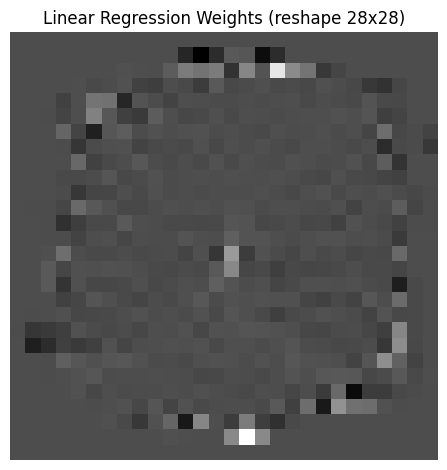

In [1]:
#!/usr/bin/env python3
"""
MNIST 0-vs-1 with Linear Regression (OLS) + thresholding.

Requirements:
  pip install scikit-learn numpy

Notes:
- We treat labels {0,1} as numeric targets for regression, then threshold at 0.5.
- This uses only LinearRegression (no logistic/softmax/etc.).
"""

import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

def load_mnist_0_vs_1():
    # Download MNIST (first time only); returns (70000, 784) and string labels
    mnist = fetch_openml("mnist_784", version=1, as_frame=False)
    X = mnist.data.astype(np.float32)
    y = mnist.target.astype(str)

    # Keep only digits '0' and '1'
    mask = (y == '0') | (y == '1')
    X = X[mask]
    y = y[mask].astype(np.int64)  # convert '0'/'1' -> 0/1

    # Simple scaling to [0,1]
    X /= 255.0
    return X, y

def main():
    X, y = load_mnist_0_vs_1()

    # Stratified split into train/test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Fit plain Linear Regression (OLS)
    lr = LinearRegression(n_jobs=-1)
    lr.fit(X_train, y_train)

    # Continuous outputs
    y_score_test = lr.predict(X_test)

    # Default threshold 0.5
    y_pred_default = (y_score_test >= 0.5).astype(int)
    acc_default = accuracy_score(y_test, y_pred_default)

    print("=== Linear Regression (OLS) on MNIST 0 vs 1 ===")
    print(f"Test accuracy @ threshold 0.5: {acc_default:.4f}")

    # (Optional) Tune threshold on a validation split from train
    # to squeeze a bit more accuracy from the regressor.
    X_tr, X_val, y_tr, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=123, stratify=y_train
    )
    lr_tune = LinearRegression(n_jobs=-1)
    lr_tune.fit(X_tr, y_tr)
    y_score_val = lr_tune.predict(X_val)

    thr_grid = np.linspace(0.0, 1.0, 101)
    val_accs = []
    for t in thr_grid:
        val_accs.append(accuracy_score(y_val, (y_score_val >= t).astype(int)))
    best_idx = int(np.argmax(val_accs))
    best_thr = float(thr_grid[best_idx])
    best_val_acc = val_accs[best_idx]
    print(f"Best validation threshold: {best_thr:.2f} (val acc: {best_val_acc:.4f})")

    # Refit on full train and evaluate with tuned threshold
    lr.fit(X_train, y_train)
    y_pred_tuned = (lr.predict(X_test) >= best_thr).astype(int)
    acc_tuned = accuracy_score(y_test, y_pred_tuned)
    print(f"Test accuracy @ tuned threshold {best_thr:.2f}: {acc_tuned:.4f}")

    # Detailed test metrics (using tuned threshold)
    print("\nConfusion Matrix (test):")
    print(confusion_matrix(y_test, y_pred_tuned))
    print("\nClassification Report (test):")
    print(classification_report(y_test, y_pred_tuned, digits=4))

    # (Nice to have) Save the learned weight image for inspection
    try:
        import matplotlib.pyplot as plt
        w = lr.coef_.reshape(28, 28)
        plt.imshow(w, cmap="gray")
        plt.title("Linear Regression Weights (reshape 28x28)")
        plt.axis("off")
        plt.tight_layout()
        plt.savefig("lr_weights_0_vs_1.png", dpi=150)
        print('Saved weight visualization to "lr_weights_0_vs_1.png"')
    except Exception as e:
        print(f"(Skipping weight image: {e})")

if __name__ == "__main__":
    main()


In [2]:
#!/usr/bin/env python3
"""
MNIST 3-vs-8 with Linear Regression (OLS) + thresholding.
"""

import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

def load_mnist_3_vs_8():
    mnist = fetch_openml("mnist_784", version=1, as_frame=False)
    X = mnist.data.astype(np.float32)
    y = mnist.target.astype(str)

    # only keep digits 3 and 8
    mask = (y == '3') | (y == '8')
    X = X[mask]
    y = y[mask].astype(np.int64)   # now labels are int but still 3 or 8

    # convert to 0 and 1 so regression fits easily
    # map 3 -> 0, 8 -> 1 (arbitrary but consistent)
    y = (y == 8).astype(np.int64)

    # normalize pixel intensity
    X /= 255.0
    return X, y

def main():
    X, y = load_mnist_3_vs_8()

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    lr = LinearRegression(n_jobs=-1)
    lr.fit(X_train, y_train)

    y_score = lr.predict(X_test)
    y_pred = (y_score >= 0.5).astype(int)

    print("=== Linear Regression (OLS) on MNIST 3 vs 8 ===")
    print("Test accuracy:", accuracy_score(y_test, y_pred))
    print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=4))

if __name__ == "__main__":
    main()


=== Linear Regression (OLS) on MNIST 3 vs 8 ===
Test accuracy: 0.9574087329992842

Confusion Matrix:
 [[1368   61]
 [  58 1307]]

Classification Report:
               precision    recall  f1-score   support

           0     0.9593    0.9573    0.9583      1429
           1     0.9554    0.9575    0.9565      1365

    accuracy                         0.9574      2794
   macro avg     0.9574    0.9574    0.9574      2794
weighted avg     0.9574    0.9574    0.9574      2794

